# KNN model for predicting racket age using datasets P1, P2, and P3, based on energy per band features - Sound

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the age of a racket (P1, P2, P3) based on sound features extracted from audio files. The workflow involves reading `.wav` files, extracting frequency peaks and energy per frequency band using FFT, and training the model using these features. The model's performance is evaluated using accuracy metrics and visualized through scatter plots and a confusion matrix.

### Import libraries

In [7]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score


Readwav function

In [ ]:
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../../../Functions/')

import file

In [16]:
from ..Functions.readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../Data_Clean/new_RB")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


ImportError: attempted relative import with no known parent package

Spectrum

In [ ]:
def spectrumFromWav(wavFile,):
    spectrum = fft(wavFile[:, 1]) 
    return abs(spectrum[:len(spectrum) // 2])  


spectrumVect=[]

# for i in range(len(testWavFileVect)):
#     spectrum = spectrumFromWav(testWavFileVect[i], samplerateVect[i])
#     freqs = np.fft.fftfreq(len(spectrum) * 2, d=1/samplerateVect[i])[:len(spectrum)]
#     filtered_spectrum = spectrum[(freqs >= 150) & (freqs <= 1000)]
#     spectrumVect.append(filtered_spectrum)

# for idx, spectrum in enumerate(spectrumVect[:3]):
#     plt.figure(figsize=(6, 3))
#     plt.plot(spectrum)
#     plt.title(f"Spectrum {idx + 1}")
#     plt.xlabel("Frequency Bin")
#     plt.ylabel("Magnitude")
#     plt.show()



Extract each peak and store

In [ ]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values

# extractNPeak(20,spectrumVect[0])

Energy

In [ ]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

# Main

In [ ]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}


allWavFile=[]
allWavFileSampleRate=[]
allWavFileLabel=[]
allWavFileP1=[]
allWavFileP2=[]
allWavFileP3=[]

sampleRateFolderP1=[]
sampleRateFolderP2=[]
sampleRateFolderP3=[]

#P1
for raquetteType in raquetteTypeList:
    sampleRateFolderP1_type,fileFolderP1,filesP1 = readWavFolder("../../Data_Clean/new_"+raquetteType)
    for i in range(len(fileFolderP1)):
        allWavFileP1.append(fileFolderP1[i])
        sampleRateFolderP1.append(sampleRateFolderP1_type[i])


#P2
sampleRateFolderP2,allWavFileP2,filesP2 =readWavFolder("../../Data_Clean/Free_Condition/P2")



#P3
sampleRateFolderP3,allWavFileP3,filesP3 =readWavFolder("../../Data_Clean/Free_Condition/P3")



# Find the minimum length among the three lists
min_len = min(len(allWavFileP1), len(allWavFileP2), len(allWavFileP3))

# Reduce each list to the minimum length
allWavFileP1 = allWavFileP1[:min_len]
allWavFileP2 = allWavFileP2[:min_len]
allWavFileP3 = allWavFileP3[:min_len]

print("Len(allWavFileP1)",len(allWavFileP1),"Len(allWavFileP2)",len(allWavFileP2),"Len(allWavFileP3)",len(allWavFileP3))

# print(len(sampleRateFolderP1))

for i in range(len(allWavFileP1)):
    allWavFile.append(allWavFileP1[i])
    allWavFileSampleRate.append(sampleRateFolderP1[i])
    allWavFileLabel.append("P1")
for i in range(len(allWavFileP2)):
    allWavFile.append(allWavFileP2[i])
    allWavFileSampleRate.append(sampleRateFolderP2[i])
    allWavFileLabel.append("P2")
for i in range(len(allWavFileP3)):
    allWavFile.append(allWavFileP3[i])
    allWavFileSampleRate.append(sampleRateFolderP3[i])
    allWavFileLabel.append("P3")



Len(allWavFileP1) 213 Len(allWavFileP2) 213 Len(allWavFileP3) 213
213


In [ ]:
X_HZAllWavFile = []
X_AmplitudeAllWavFile = []

# print(len(allWavFile))

for i in range(len(allWavFile)):
    print(i)

    wavFile=allWavFile[i]
    samplerate=allWavFileSampleRate[i]

    # Compute the spectrum using FFT
    spectrum = spectrumFromWav(wavFile)
    
    # Compute the frequency bins
    freqs = np.fft.fftfreq(len(spectrum) * 2, d=1/samplerate)[:len(spectrum)]
    
    # Extract peaks from the spectrum
    X_Amplitude,X_HZ = energy_per_frequency_band_from_spectrum(spectrum, freqs[(freqs >= 150) & (freqs <= 1000)], band_width=100)


    # Normalize X_Amplitude
    X_Amplitude = np.array(X_Amplitude) / np.max(X_Amplitude)


    X_HZAllWavFile.append(X_HZ)
    X_AmplitudeAllWavFile.append(X_Amplitude)


# print(X_AmplitudeAllWavFile)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Combine features into X
X = np.hstack([np.array(X_HZAllWavFile), np.array(X_AmplitudeAllWavFile)])
# X=np.array(X_AmplitudeAllWavFile)


# print(len(np.array(X).flatten()))
print(len(allWavFileLabel))

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allWavFileLabel)

# print(y)
print(len(X),len(y))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


639
639 639


In [ ]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean         1.00000       0.984375
1              1   uniform  manhattan         1.00000       0.984375
2              1   uniform  chebyshev         1.00000       0.976562
3              1   uniform  minkowski         1.00000       0.984375
4              1  distance  euclidean         1.00000       0.984375
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski         0.95499       0.937500
156           20  distance  euclidean         1.00000       0.945312
157           20  distance  manhattan         1.00000       0.953125
158           20  distance  chebyshev         1.00000       0.945312
159           20  distance  minkowski         1.00000       0.945312

[160 rows x 5 columns]


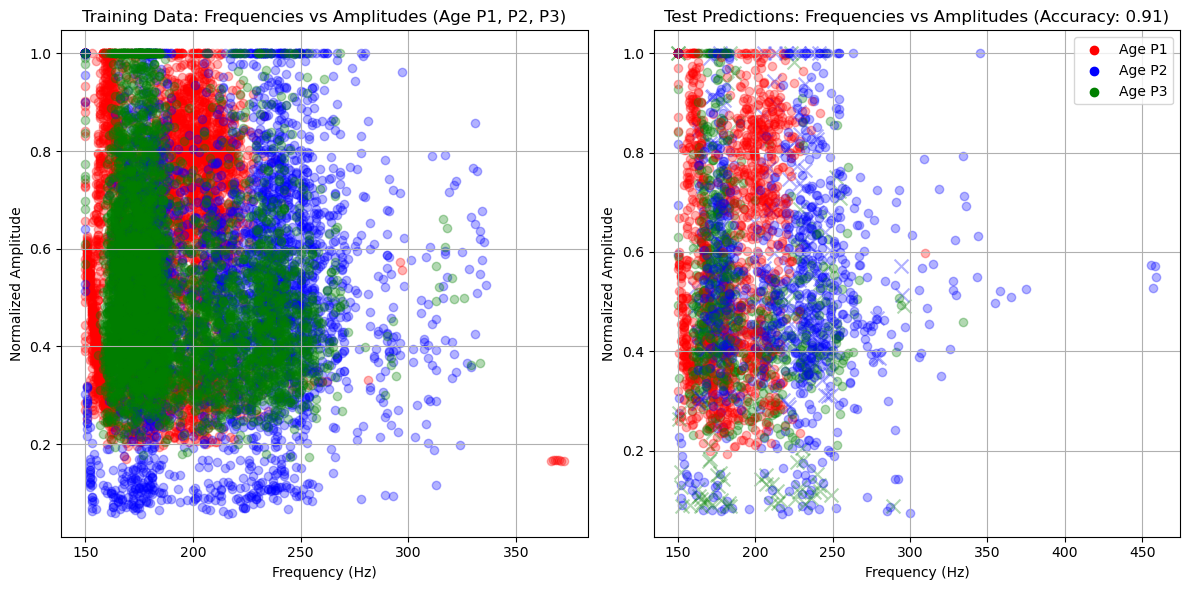

In [ ]:
# Define a color map for the labels
colors = ['red', 'blue', 'green']  # Colors for each label: P1, P2, P3
ageList = {"P1": 0, "P2": 1, "P3": 2}  # Dictionary for age labels
label_names = list(ageList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Age P1, P2, P3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2)  # Second subplot for test data with predictions
y_pred = knn.predict(X_test)  # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]
    
    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550
    
    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], 
                   marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"Age {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

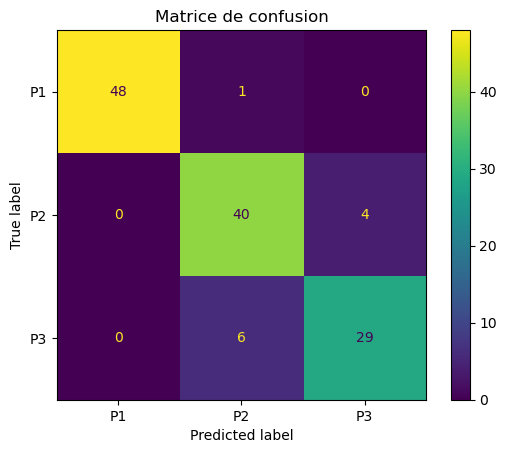

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
